## Setup the libraries

In [ ]:
!pip install spacy --upgrade -q

In [ ]:
import spacy
import pandas as pd

from spacy.lang.pt.stop_words import STOP_WORDS

import seaborn as sns

import string

import re

import numpy as np

In [ ]:
spacy.__version__

'3.4.2'

In [ ]:
nlp = spacy.blank("pt")

## Step 1 - Data Preparation

#### Loading the dataset to Pandas

In [ ]:
df = pd.read_csv("https://gist.githubusercontent.com/johnidm/582cfeadd2bf418df4539c9422f824d2/raw/twitter-sentiment-pt-BR-md-2-l.csv")
df.head()

,tweet_text,sentiment
0,Mas tu não és feio :( @SavageFluxXx__,0
1,@SamaraPaivas Você que pensa :),1
2,te amo demais :( https://t.co/leUzS65WrG,0
3,@nicko_donis lindo! :),1
4,"@B_kirikihira Oi, tem sim! Visite nossos canai...",1


In [ ]:
df.shape

(20000, 2)

#### Applaying the preprocessing task

We are shuffling the dataset with `df.sample`. This is important to split the data into training, development and testing dataset equalized parts.

In [ ]:
REGX_USERNAME = r"@[A-Za-z0-9$-_@.&+]+"
REGX_URL = r"https?://[A-Za-z0-9./]+"

def preprocessing(text):
  text = text.lower()

  text = re.sub(REGX_USERNAME, ' ', text)
  text = re.sub(REGX_URL, ' ', text)

  emojis = {
      ':)': 'emocaopositiva',
      ':(': 'emocaonegativa'
  }

  for e in emojis:
    text = text.replace(e, emojis[e])

  tokens = [token.text for token in nlp(text)]

  tokens = [t for t in tokens if 
              t not in STOP_WORDS and 
              t not in string.punctuation and 
              len(t) > 3]

  tokens = [t for t in tokens if not t.isdigit()]

  return " ".join(tokens)

In [ ]:
df["tweet_text_clean"] = df["tweet_text"].apply(preprocessing)

df.head()

,tweet_text,sentiment,tweet_text_clean
0,Mas tu não és feio :( @SavageFluxXx__,0,feio emocaonegativa
1,@SamaraPaivas Você que pensa :),1,pensa emocaopositiva
2,te amo demais :( https://t.co/leUzS65WrG,0,emocaonegativa
3,@nicko_donis lindo! :),1,lindo emocaopositiva
4,"@B_kirikihira Oi, tem sim! Visite nossos canai...",1,visite canais saiba projeto incrivel emocaopos...


#### Exploring the dataset

In [ ]:
sns.set(font_scale=1.4)

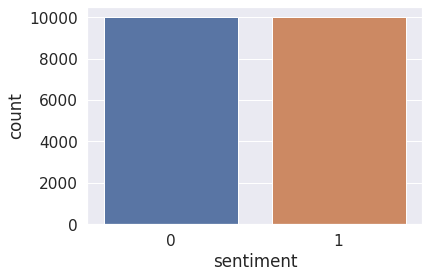

In [ ]:
sns.countplot(x = df['sentiment'], label = 'Count');

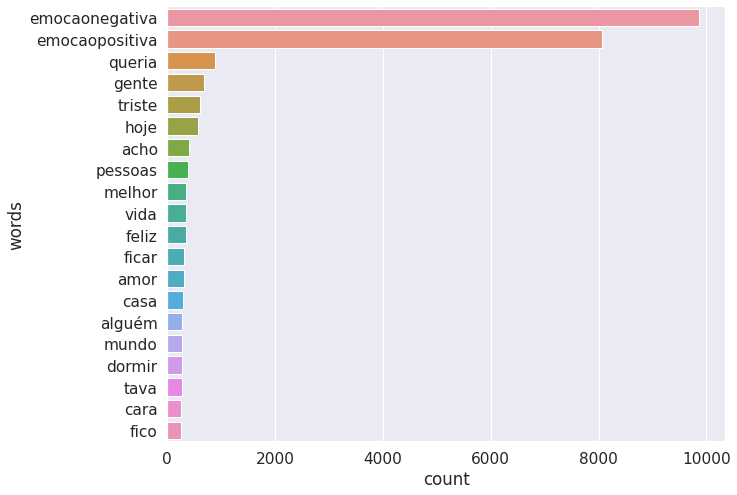

In [ ]:
counts = df["tweet_text_clean"].str.split(expand=True).stack().value_counts()[:20]
ax = sns.barplot(y=counts.index, x=counts)

ax.set(xlabel='count', ylabel='words');
ax.figure.set_size_inches(10, 8)

#### Splitting and converting to a spaCy binary format 


In [ ]:
dataset = list(df[["tweet_text_clean", "sentiment"]].sample(frac=1).itertuples(index=False, name=None))

train_data = dataset[:15000]
dev_data = dataset[15000:18000]
test_data = dataset[18000:]

print(f"Total: {len(dataset)} - Train:  {len(train_data)} - Dev: {len(dev_data)} - Test: {len(test_data)}")

Total: 20000 - Train:  15000 - Dev: 3000 - Test: 2000


In [ ]:
def convert(data, outfile):
    db = spacy.tokens.DocBin()

    docs = []
    for doc, label in nlp.pipe(data, as_tuples=True):

        doc.cats["POS"] = label == 1
        doc.cats["NEG"] = label == 0
     
        db.add(doc)
    
    db.to_disk(outfile)

convert(train_data, "./train.spacy")
convert(dev_data, "./dev.spacy")
convert(test_data, "./test.spacy")

## Step 2 - Pipeline Train

#### Create a configuration file

In [ ]:
!python -m spacy init config --lang pt --pipeline textcat --optimize efficiency --force config.cfg 

2022-11-04 14:11:22.607714: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: pt
- Pipeline: textcat
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


### Train step

In [ ]:
!python -m spacy train config.cfg --paths.train ./train.spacy  --paths.dev ./dev.spacy --output model --verbose

2022-11-04 14:11:34.519725: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[2022-11-04 14:11:35,286] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
DEBUG:spacy:Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: model
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-11-04 14:11:35,408] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-04 14:11:35,420] [DEBUG] Loading corpus from path: dev.spacy
DEBUG:spacy:Loading corpus from path: dev.spacy
[2022-11-04 14:11:35,422] [DEBUG] Loading corpus from path: train.spacy
DEBUG:spacy:Loading corpus from path: train.spacy
[2022-11-04 14:11:35,422] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-04 14:11:35,427] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-04 14:11:35,429] [INFO] Finish

## Step 03 - Pipeline Evaluation

In [ ]:
!python -m spacy evaluate ./model/model-best/ ./test.spacy

2022-11-04 14:12:46.620310: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
ℹ Using CPU

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   98.74 
SPEED               104590


=========================== Textcat F (per label) ===========================

          P       R       F
POS   97.73   99.80   98.75
NEG   99.79   97.69   98.73


======================== Textcat ROC AUC (per label) ========================

      ROC AUC
POS      1.00
NEG      1.00



## Step 04 - Test Pipeline

In [ ]:
texts = [":)", "Estou muito triste hoje", "Estou muito feliz hoje"]

In [ ]:
nlp = spacy.load("./model/model-best")

for text in texts:
    doc = nlp(preprocessing(text))
    print(doc.cats,  "-",  text)

{'POS': 0.9766181707382202, 'NEG': 0.02338179387152195} - :)
{'POS': 0.5225540399551392, 'NEG': 0.4774459898471832} - Estou muito triste hoje
{'POS': 0.8422360420227051, 'NEG': 0.15776395797729492} - Estou muito feliz hoje


#### Evaluate Architetures

In this example, we are using configuration files to train a binary text classification. According to the dataset labeled used in this notebook.

#### CNN

Config file:

- https://gist.githubusercontent.com/johnidm/6a7bc5cda629be118765b44d1910710d/raw/68ed20d25afc26531b6d0ef70a46483aee3e8c75/single_label_cnn.cfg


In [ ]:
!curl -O https://gist.githubusercontent.com/johnidm/6a7bc5cda629be118765b44d1910710d/raw/68ed20d25afc26531b6d0ef70a46483aee3e8c75/single_label_cnn.cfg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2261  100  2261    0     0   5345      0 --:--:-- --:--:-- --:--:--  5332


In [ ]:
!python -m spacy train single_label_cnn.cfg --paths.train ./train.spacy  --paths.dev ./dev.spacy --output model-cnn --verbose

2022-11-04 14:12:54.660891: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[2022-11-04 14:12:55,412] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
DEBUG:spacy:Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: model-cnn
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-11-04 14:12:55,543] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-04 14:12:55,556] [DEBUG] Loading corpus from path: dev.spacy
DEBUG:spacy:Loading corpus from path: dev.spacy
[2022-11-04 14:12:55,558] [DEBUG] Loading corpus from path: train.spacy
DEBUG:spacy:Loading corpus from path: train.spacy
[2022-11-04 14:12:55,558] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-04 14:12:55,563] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-04 14:12:55,566] [INFO] Fi

In [ ]:
nlp = spacy.load("./model-cnn/model-best")

for text in texts:
    doc = nlp(preprocessing(text))
    print(doc.cats,  "-",  text)

{'POS': 1.0, 'NEG': 1.0410988419135772e-35} - :)
{'POS': 6.84361054936744e-07, 'NEG': 0.9999992847442627} - Estou muito triste hoje
{'POS': 0.9999998807907104, 'NEG': 9.29914776293117e-08} - Estou muito feliz hoje



#### Bow
Config file

- https://gist.githubusercontent.com/johnidm/ad8510dbb59e77b760e1f88417d328bc/raw/40ecf6ce9438137b6c2860fd28620674d26f3d92/single_label_bow.cfg


In [ ]:
!curl -O https://gist.githubusercontent.com/johnidm/ad8510dbb59e77b760e1f88417d328bc/raw/40ecf6ce9438137b6c2860fd28620674d26f3d92/single_label_bow.cfg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2100  100  2100    0     0   4535      0 --:--:-- --:--:-- --:--:--  4535


In [ ]:
!python -m spacy train single_label_cnn.cfg --paths.train ./train.spacy  --paths.dev ./dev.spacy --output model-bow --verbose

2022-11-04 14:25:18.777586: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[2022-11-04 14:25:19,553] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
DEBUG:spacy:Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: model-bow
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-11-04 14:25:19,678] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-04 14:25:19,693] [DEBUG] Loading corpus from path: dev.spacy
DEBUG:spacy:Loading corpus from path: dev.spacy
[2022-11-04 14:25:19,694] [DEBUG] Loading corpus from path: train.spacy
DEBUG:spacy:Loading corpus from path: train.spacy
[2022-11-04 14:25:19,695] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-04 14:25:19,699] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-04 14:25:19,700] [INFO] Fi

In [ ]:
nlp = spacy.load("./model-bow/model-best")

for text in texts:
    doc = nlp(preprocessing(text))
    print(doc.cats,  "-",  text)

{'POS': 1.0, 'NEG': 1.0410988419135772e-35} - :)
{'POS': 6.84361054936744e-07, 'NEG': 0.9999992847442627} - Estou muito triste hoje
{'POS': 0.9999998807907104, 'NEG': 9.29914776293117e-08} - Estou muito feliz hoje


#### Ensemble 

Config file 

- https://gist.githubusercontent.com/johnidm/3d0b335b5872ef6d7305b4a89a0b9ae1/raw/a3df807d3cdd5fe5e3d04fe404450e2cff2a52e5/single_label_ensemble.cfg


In [ ]:
!curl -O https://gist.githubusercontent.com/johnidm/3d0b335b5872ef6d7305b4a89a0b9ae1/raw/a3df807d3cdd5fe5e3d04fe404450e2cff2a52e5/single_label_ensemble.cfg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2680  100  2680    0     0   6175      0 --:--:-- --:--:-- --:--:--  6189


In [ ]:
!python -m spacy train single_label_cnn.cfg --paths.train ./train.spacy  --paths.dev ./dev.spacy --output model-ensemble --verbose

2022-11-04 14:37:38.052796: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
[2022-11-04 14:37:38,782] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
DEBUG:spacy:Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory: model-ensemble
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2022-11-04 14:37:38,918] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-11-04 14:37:38,932] [DEBUG] Loading corpus from path: dev.spacy
DEBUG:spacy:Loading corpus from path: dev.spacy
[2022-11-04 14:37:38,934] [DEBUG] Loading corpus from path: train.spacy
DEBUG:spacy:Loading corpus from path: train.spacy
[2022-11-04 14:37:38,934] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-11-04 14:37:38,939] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-11-04 14:37:38,940] [INF

In [ ]:
nlp = spacy.load("./model-ensemble/model-best")

for text in texts:
    doc = nlp(preprocessing(text))
    print(doc.cats,  "-",  text)

{'POS': 1.0, 'NEG': 1.0410988419135772e-35} - :)
{'POS': 6.84361054936744e-07, 'NEG': 0.9999992847442627} - Estou muito triste hoje
{'POS': 0.9999998807907104, 'NEG': 9.29914776293117e-08} - Estou muito feliz hoje
